In [1]:
import pandas as pd
import numpy as np

In [2]:
#codigo para descargar datasets populares
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

**Nota**: las instancias son cada una de las observaciones y las clases son los grupos.

Por lo general los datasets descargados así tienen una estructura de diccionario con las siguientes llaves.

**DESCR**: es una descripción del conjunto de datos.

**data**: es un arreglo que contiene una fila por instancia y una columna por variable.

**target**: es un arreglo que contiene los valores de la variable respuesta. 

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

En este caso se tienen 70000 observaciones y las 784 columnas representan cada una de las intensidades de los píxeles de las imágenes (28*28 = 784)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].to_numpy() #se debe convertir en un arreglo
some_digit_image = some_digit.reshape(28,28) #posteriormente en una matriz de intensidades de píxeles

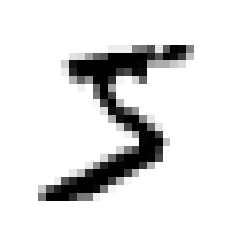

In [5]:
plt.imshow(some_digit_image, cmap = "binary") #función para mostrar imágenes
plt.axis("off") #quitando los ejes
plt.show()

In [6]:
y[0] #valor de la variable respuesta

'5'

Como la variable respuesta es una cadena de texto, se convierte a enteros, pues la mayoría de algoritmos de ML esperan números.

In [7]:
y = y.astype(np.uint8) #cambiando el tipo de la variable respuesta

Se debe seleccionar conjuntos de entrenamiento y de prueba, sin embargo este conjunto de datos ya está dividio. Las primeras 60000 observaciones son el conjunto de entrenamiento y las otras 10000 el de prueba.

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

# Entrenando un clasificador binario

Antes de clasificar en varias categorías se procede a determinar si un número es 5 o no lo es.

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Se escoge un clasificador y se entrena, en este caso se utiliza un Descenso de Gradiente Estocástico (Stochastic Gradient Descent (SGD)) porque maneja bien conjuntos de datos grandes.

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42) 
#el SGD depende de aleatoriedad durante el entrenamiento, si se quiere reproducir resultados, se debe usar random_state
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Se va a usar para predecir alguna imagen.

In [11]:
sgd_clf.predict([some_digit]) 
#ojo, el predict del sgd recibe arreglos bidimensionales, por eso se mete el vector de covariables en []

array([ True])

# Medidas de desempeño

Evaluar el desempeño de un clasificador es más dificil que de un regresor.

## Midiendo el desempeño usando cross-validation

In [12]:
from sklearn.model_selection import StratifiedKFold #kfold cross-validation por estratos
from sklearn.base import clone #crea una copia de un estimador con los mismos parámetros pero sin ajuste

In [13]:
skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True) #generando el objeto que va a partir por estratos

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_folds = X_train.iloc[test_index]
    y_test_folds = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_test_folds))

0.9669
0.91625
0.96785


Lo que hace el código anterior es generar índices segun estratos (True o False en este caso) y luego generar el k-fold cross validation en el set de entrenamiento. 

In [14]:
#haciendo simplemente k-fold cross-validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.base import BaseEstimator

class Never5classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [16]:
never_5_clf = Never5classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

Notar que la clase creada devuelve como si no fueran 5, luego todas las salidas son False. Por otro lado, solo 10% de los números en el set de entrenamiento son 5, por ende la clase creada al predecir va a acertar en al rededor del 90%. Por esto la precisión no es la medida preferida para medir el desempeño de los clasificadores.

## Matriz de confusión

La idea de la matriz de confusión es contar el número de veces que las instancias de la clase A fueron confundidas con las de la clase B, por ejemplo para saber el número de veces que el clasificador confundió imágenes de cincos con treces, se debe mirar la quinta fila y la tercera columna de la matriz de confusión.

Para tener la matriz de confusión se debe tener un conjunto de predicciones para poder comparalas con la variable respuesta.

In [17]:
#uso de cross_val_predict
from sklearn.model_selection import cross_val_predict
'''hace exactamente lo mismo que cross_val_scores a excepción de que
en vez de retornar scores, retorna las predicciones hechas en cada subconjunto de prueba'''

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [18]:
#construyendo la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) #notar el orden, respuesta y predichos

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

En este caso la primera fila representa los que no son 5 y la segunda los que sí (estas son las clases de verdad) y las columnas representan las predicciones. 
Se tiene que la entrada 1,1 es los no 5 predichos como no 5 (verdaderos negativos), la entrada 1,2 los no 5 predichos como 5 (falsos positivos), la entrada 2,1 es los 5 predichos como no 5 (falsos negativos) y la entrada 2,2 los 5 predichos como 5 (verdaderos positivos).

In [19]:
#con predicciones perfectas se obtiene un matriz diagonal
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Se tienen varias métricas:

TP: True Positives, FP : False Positives, FN: False Negatives.

precisión = $\frac{TP}{TP + FP}$ mira el porcentaeje de las predicciones realmente correctas entre todas las que fueron predichas como correctas.

sensibilidad = $\frac{TP}{TP + FN}$ mira el porcentaje de las predicciones fueron hechas correctas entre todas que deberían haber sido clasificadas como correctas. 

Este cálculo no es necesario hacerlo a mano,se puede realizar como se muestra a continuación. 

In [20]:
#importando presicion_score (precisión) y recall_score (sensibilidad)
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

Estos resultados significan que entre lo que clasifica como 5 solo acierta el 83.7% de las veces y solo detecta el 65.1% de los 5.

Es conveniente combinar estas dos métricas en una sola y esto se hace a través del $F_1$ que se define de la siguiente manera (es la media armónica entre el precision y el recall):
$$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} \ = 2\frac{precison x recall}{precison + recall}$$
En consecuencia el $F_1$ del clasificador solo será alto si se tienen precisión y sensibilidad altas.

In [21]:
#implementación en scikit
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

**Nota**: por lo general el $F_1$ favorece clasificadores que tienen precisión y sensibilidad similares, entonces es algo a lo que hay que prestarle atención. Además, se debe tener en cuenta que al aumentar la precisión la sensibilidad disminuye y viceversa.

## Intercambio entre la precisión y la sensibilidad (Precision/Recall trade-off)

Para cada instancia computa un score basado en una función de decisión. Si ese score es mayor a cierto límite, asigna la instancia a la clase positiva, en caso contrario a la negativa.

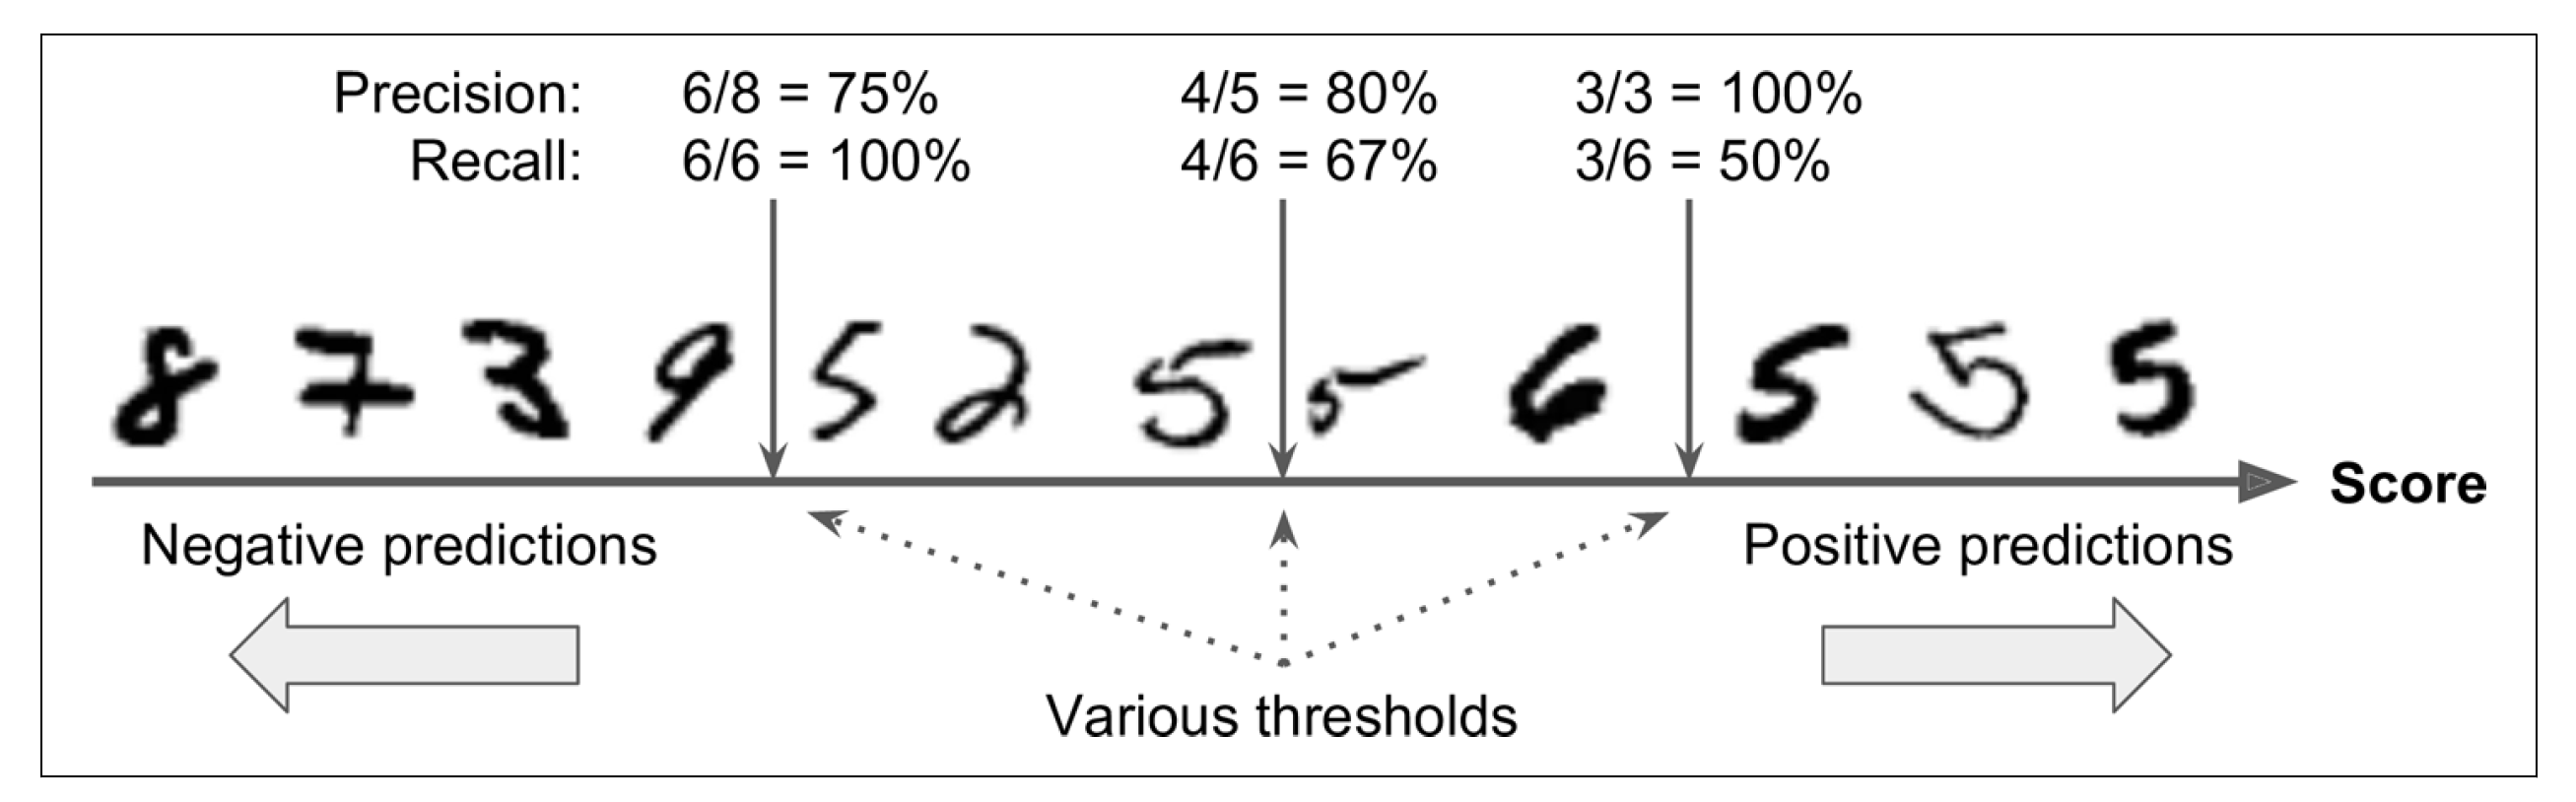

Cabe resaltar que inicialmente se tiene una precisión del 80% (4 de las 5 instancias predichas como positivas son realmente positivas) y una sensibilidad de 67% (solo 4 instancias de las 6 correctas fueron predichas como correctas). Sin embargo, si se aumenta el límite (flecha de la derecha), todas las predicciones señaladas como correctas lo son realmente (100% de precisión), pero solo 3 de las seis instancias correctas fueron predichas como tal (50% de sensibilidad). Ahora, si se mueve a la izquiera el límite se tiene que la precisión disminuye pues a pesar de que todas las instancias correctas fueron clasificadas así, se tiene un aumento de los falsos positivos (precisión del 75%) pero la sensibilidad aumenta pues de entre todas las instancias correctas, ninguna fue clasificada como incorrecta (sensibilidad del 100%).

In [22]:
#accediendo a los scores del SGD (la función de decisión es aquella que retorna los scores para cada predicción)
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) #así es como funciona la clasificación de correcto o incorrecto
#va a retornar True entonces es una clasificación correcta según nuestro límite
y_some_digit_pred

array([ True])

El SGDClassifier usa un límite igual a cero, entonces el código anterior retorna el mismo resultado que al usar el método predict. 

In [24]:
#para usar un límite personalizado
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                             cv = 3, method = "decision_function") 
#haciendo que el cross-validation retorne el score en vez de la predicción

In [25]:
#usar precision_recall_curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

**Precision**: son los valores de la precisión teniendo en cuenta que el score sea mayor o igual que thresholds[i].


**Recall**: son los valores de la sensibilidad (en orden decreciente) tales que el elemento i es la sensibilidad cuando el score es mayor o igual que thresholds[i].

In [26]:
precisions.shape, recalls.shape, thresholds.shape

((59967,), (59967,), (59966,))

**Nota**: como se puede apreciar las precisiones y las sensibilidades poseen un elemento más que los límites, esto es porque sus últimos elementos son un 1 y un 0 respectivamente.

In [27]:
precisions

array([0.09040123, 0.09038606, 0.09038757, ..., 1.        , 1.        ,
       1.        ])

Se grafican la precisión y la sensibilidad en un mismo plano para analizar el comportamiento de las curvas en función del límite

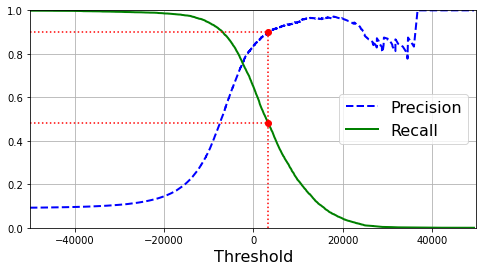

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) #(leyenda)
    plt.xlabel("Threshold", fontsize=16)        #(etiqueta del eje x)
    plt.grid(True)                              #(habilitar rejilla en el plot)
    plt.axis([-50000, 50000, 0, 1])             #(limite de los ejes xmin, xmax, ymin, ymax)



#argmax retorna la primera ocurrencia del elemento mayor
#al hacer precisions >= 90 se convierte el arreglo a uno de tipo booleano
#np.argmax retorna el índice en el que se encuentra el primer True

recall_90_precision = recalls[np.argmax(precisions >= 0.90)] #punto en el arreglo de recalls correspondiente al primer precison >= 0.9
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #punto en el arreglo de thresholds correspondiente al primer precison >= 0.9


plt.figure(figsize=(8, 4))                                                                  #tamaño del plot
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)                         #invocación de la función que crea el plot
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 #ploteando la linea vertical [xstart, xend], [ystart, yend]
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                #ploteando la línea horizontal superior
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")#ploteando la línea horizontal inferior
plt.plot([threshold_90_precision], [0.9], "ro")                                             #ploteando el punto en que el que la precisión se hace mayor o igual a 0.9
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             #lo mismo pero en la curva de la sensibilidad
plt.show()                                                                                  #mostrando el plot

Otra buena alternativa es hacer un gráfico de precisión vs sensibilidad.

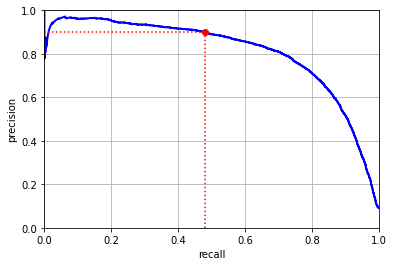

<Figure size 576x288 with 0 Axes>

In [29]:
plt.plot(recalls[:-1], precisions[:-1], color = "b", linewidth = 2)
plt.xlabel("recall")
plt.ylabel("precision")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.plot([0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.figure(figsize = (8, 4))
plt.show()

Para hacer una selección del límite puede escogerse el valor para el cual la curva empieza a decrecer, aunque esto depende mucho del proyecto en que se esté trabajando.

## La curva ROC

Es una curva muy similar a la precisión/sensibilidad pero grafica la sensibilidad (tasa de verdaderos positivos) contra la tasa de falsos positivos (la razón de las instancias negativas que son incorrectamente clasificadas)

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores) #falses positives rate, true positives rate, thresholds

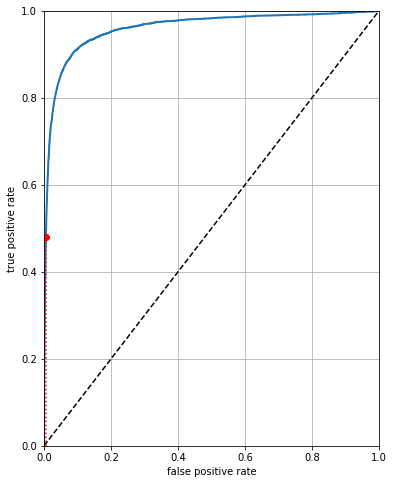

In [31]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0,1], "k--")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.grid(True)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize = (6,8))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:") 
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.show()

    

Una manera de comparar clasificadores es midiendo su area bajo la curva como se muestra a continuación. (un clasificador "perfecto" es aquel que tiene 1 como área bajo la curva).

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Nota**: se debería preferir la curva de precisión vs sensibilidad cuando la clase positiva es rara o cuando importan más los falsos positivos que los falsos negativos. En otro caso es mejor usar la curva ROC)

Ahora se va a usar un clasificador de tipo bosque aleatorio para comparar su curva ROC y su área bajo la curva con la del descenso de gradiente estocástico.

In [33]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 5, method = "predict_proba")
#se usa predict_proba porque el rf no tiene función de decisión

Lo que hace el método predict_proba de la clase RandomForestClassifier es que retorna un arreglo conteniendo una fila por instancia y una columna por clase, cada una conteniendo la probabilidad de que la instancia dada pertenezca a la clase dada (por ejemplo 70% de probabilidad de que la imagen represente un 5).

In [34]:
y_probas_forest.shape #60000 observaciones clasificadas en una de dos clases

(60000, 2)

In [35]:
#la función roc_curve espera valores de la respuesta y scores, pero se le pueden pasar probabilidades de clase
y_scores_forest = y_probas_forest[:,1] #usando la clase positiva de la probabilidad
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

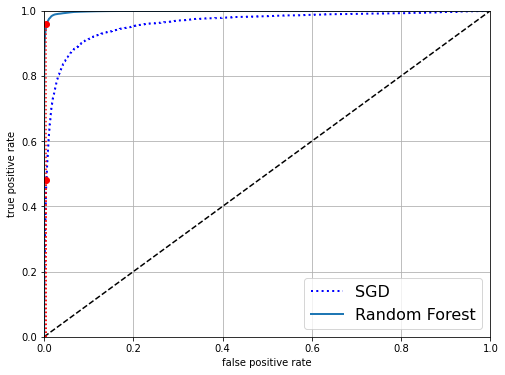

In [36]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest ,label = "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.998402186461512

In [38]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)
print(f"precision is {precision_score(y_train_5, y_train_pred_forest)} and the recall is {recall_score(y_train_5, y_train_pred_forest)}")

precision is 0.9905083315756169 and the recall is 0.8662608374838591


# Clasificación en varias clases

Algunos algoritmos son capaces de manejar múltiples clases de manera nativa, mientras que otros realmente solo sirven para hacer clasificaciones binarias estrictamente. Sin embargo hay muchas estrategias para hacer clasificación múltiple con clasificadores binarios.

Una manera de crear un sistema que pueda clasificar las diez clases es entrenar diez clasificadores binarios, uno para cada dígito. Cuando se clasifique una imagen, se obtiene el puntaje de decisión para cada clasificador y se selecciona la clase en la que se obtenga la calificación más alta. Esto es llamado uno contra el resto (one-versus-the-rest (OVR)) también llamada uno contra todos.

Otra estrategia es entrenar un clasificador binario para cada par de dígitos, esto es llamado uno contra uno (one-versus-one (OVO)). Si hay n clases esto significa que se deben entrenar $\frac{n (n-1)}{2}$ clasificadores. Cuando se quiere clasificar una imagen se debe pasar la imagen entre todos los clasificadores y ver cual clase es la que gana más duelos. La ventaja principal del OVO es que cada clasificador solo tiene que ser entrenado en la parte del conjunto de entrenamiento que tenga las dos clases que debe distinguir.

**Nota**: algunos algoritmos empeoran a medida que el tamaño del conjunto de datos aumenta, para estos algoritmos es preferido usar OVO porque es más rápido entrenar bastantes clasificadores en conjuntos pequeños de datos que pocos clasificadores en conjuntos de datos grandes. Sin embargo para la mayoría de los clasificadores binarios la estrategia preferida es OVR.

Cuando se trata de usar un clasificador binario para una clasificación múltiple, scikit lo detecta y corre OVO u OVR, dependiendo del algoritmo que se esté utilizando. 

In [42]:
#se usa un support vector classifier para clasificación múltiple

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint64)

En este caso por debajo scikit usa OVO, entrenó 45 (10*9/5) clasificadores binarios, obtuvo sus puntajes de decisión para la imagen y seleccionó la clase que ganó mayor cantidad de duelos. 

In [44]:
#viendo el score
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [45]:
np.argmax(some_digit_scores) #obteniendo el índice del puntaje más alto en la lista de puntajes

5

Cabe resaltar que a la hora de retornar los puntajes retorna un puntaje por clase, además que el puntaje más alto corresponde a la clase en que el clasificador asignó a la imagen.(en este caso las clases coinciden con los índices de las clases).

In [46]:
svm_clf.classes_ #mostrando las clases con las que se entrenó el clasificador

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint64)

Se puede forzar a scikit a usar la estrategia que se desee como se muestra a continuación.

In [47]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC()) #usando la estrategia uno contra todos
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint64)

In [48]:
#entrenando un stochastic gradient descent
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint64)

En esta ocasión scikit no tuvo que recurrir a las estrategias OVO, OVR pues los SGD (también los RFC) pueden clasificar clases directamente. La función de decision retorna un valor para cada una de las clases. 

In [49]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy") #haciendo cross-validation

array([0.87365, 0.85835, 0.8689 ])

In [51]:
#se puede mejorar este rendimiento escalando los valores de las covariables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

# Análisis de error

Se quieren encontrar maneras de mejorar el desempeño del modelo, una de ellas es analizar la clase de errores que comete

In [52]:
#mirando a la matriz de confusión 
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

Puede que la visualización en números no revele mucho, por eso es conveniente una representación visual de la matriz.

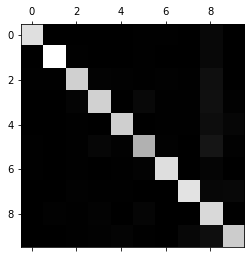

In [53]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

En general se ve bastante bien pues la mayoría de imágenes están en la diagonal principal, lo que significa que fueron clasificadas correctamente. Sin embargo, la casilla del 5 se ve ligeramente más oscura que las demás; esto puede ser debido a que el clasificador no funciona tan bien en la categoría de los 5 o que hay muy poquitos 5 en el conjunto de datos.

En vez de mirar solamente a la matriz así, se puede considerar también una representación de los errores, la cual se obtiene a través de dividir cada valor en la matriz de confusión entre el número de imágenes en la categoria correspondiente, con el fin de comparar tasas de error en vez de errores absolutos.

In [55]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

In [61]:
np.fill_diagonal(norm_conf_mx, 0)

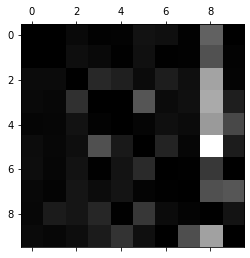

In [62]:
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

# Clasificación multietiqueta

Es una clasificación en la que se pretende clasificar varias clases, retornando si se encuentran o no presentes en la entrada que se da a la hora de realizar predicciones. 

In [64]:
#ejemplo
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [65]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [66]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

El código anterior crea un arreglo en el cual para cada valor de la covariable se tienen dos valores de la variable respuesta, luego se crea un objeto que permite hacer una clasificación multi etiqueta.

In [67]:
knn_clf.predict([some_digit])

array([[False,  True]])

Existen múltiples maneras de evaluar un clasificador de esta naturaleza y seleccionar la métrica correcta depende de en qué se esté trabajando, sin embargo un enfoque es medir el puntaje $F_1$ para cada etiqueta individual, luego simplemente tomar el promedio. 

In [68]:
#calculando el F1 a través de todos los valores de la respuesta
y_train_knn_predict = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_predict, average = "macro")

0.976410265560605

# Clasificación de varias salidas

Es una generalización de lo anterior, donde no solo cada salida de la variable respuesta está limitada a dos clases sino a más de ellas.

In [70]:
#creación de eliminador de ruido
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [91]:
def plot_digit(data):
    if (not type(data) == np.ndarray) and (type(data) == pd.core.frame.DataFrame):
        data = data.to_numpy()
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

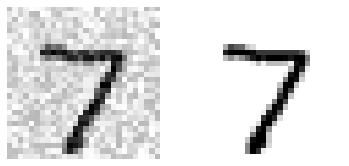

In [92]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[:some_index+1])
plt.subplot(122); plot_digit(y_test_mod[:some_index+1])
plt.show()

In [95]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod[:some_index+1])

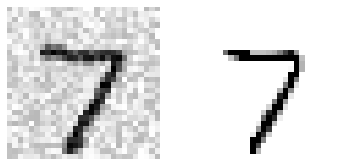

In [96]:
plt.subplot(121); plot_digit(X_test_mod[:some_index+1])
plt.subplot(122); plot_digit(clean_digit)
plt.show()